# <center> Импорт библоиотек <center>

*NOTE*: не забудьте соствить список библиотек, необходимых для реализации ваших решений, и представить их в файле `requirements.txt`.

In [394]:
import pickle
import random
import json
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score , accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings

warnings.filterwarnings('ignore')

# <center> Чтение данных <center>

Тренировчные данные представлены в виде файла в формате JSON. В котором верхенеуровневый ключ -- это номер образца (бакетрии). Каждый словарь по бактериям содержит название штамма и результаты масс-спектрометрического анализа, которые представлены следующими полями: масса к заряду (m/z), время (time), интенсивность пика (Intens.), разрешение (Res.), площадь пика (Area), относительная интенсивность (Rel. Intens.), ширина на полувысоте (FWHM=full width at half-maximum intensity). Каждый штамм будет представлен несколькими бактериями.

In [408]:
with open('train.json', 'rb') as fp:
    train_d = json.load(fp)
train_df = pd.DataFrame(json.loads(train_d)).T

In [409]:
train_df.shape

(256, 10)

In [410]:
train_df.head(2)

,strain,m/z,time,Intens.,SN,Res.,Area,Rel. Intens.,FWHM,Bk. Peak
0,Acinetobacter baumani_121 skin,"[2131.496344969094, 2259.721110106408, 2588.85...","[46140.80006771147, 47487.35689905193, 50777.8...","[2894.089294433594, 886.8892822265625, 868.547...","[10.14621708940436, 3.128197998996987, 3.13016...","[501.3893306058393, 554.1613032118989, 570.494...","[20801.59355425023, 5168.433783919987, 5449.07...","[0.07505194053740191, 0.02299955353863887, 0.0...","[4.251180100688543, 4.077731694741487, 4.53790...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Acinetobacter baumani_126,"[2132.413484429545, 2589.569703463259, 2718.11...","[46150.57342911904, 50784.81044928727, 52012.3...","[1608.209228515625, 2417.604553222656, 859.648...","[5.653855828544429, 8.654048108890505, 3.10129...","[444.1771425249818, 635.5107637820196, 483.527...","[10814.55846969845, 12028.48312655044, 5520.91...","[0.02893426423838925, 0.04349658472700257, 0.0...","[4.800817692480905, 4.074784962023841, 5.62141...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [411]:
## Посмотрим сколько классов данных и сколько примеров на каждый класс
train_df.groupby('strain').agg({'strain': "count"})

,strain
strain,
Acinetobacter baumani_121 skin,9
Acinetobacter baumani_126,9
Acinetobacter baumani_352 blood,10
Acinetobacter baumani_377 blood,11
Acinetobacter baumani_503 blood,11
Acinetobacter baumani_63,9
Acinetobacter baumani_64,11
Acinetobacter baumani_73,10
Acinetobacter baumani_74,11


Так как тренировочный набор данных не очень большой, дополним его симмулированными данными. Для этого составим дополнительные примеры из существующих. Зададим seed для воспроизводимости результатов.

In [412]:
# для начала орпеделим количестов пиков в масс-спектрах
train_df.loc[:,'n_peak'] = train_df['m/z'].apply(len)

In [413]:
def get_dif(x):
    return max(x) - min(x)

In [414]:
# посмотрим на сколько по количеству строк (пиков) различаются таблицы внутри каждого штамма
peaks_dif = train_df.groupby(['strain']).agg({'n_peak': get_dif})

<AxesSubplot:xlabel='n_peak', ylabel='Count'>

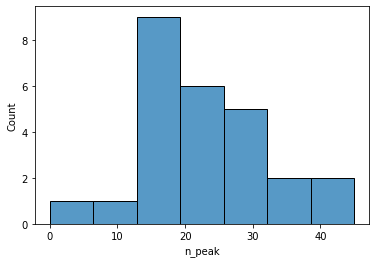

In [415]:
sns.histplot(peaks_dif.n_peak)

In [416]:
# будем использовать среднюю разности для варьирвания числа пиков в сгенерированных данных
mean_dif = int(peaks_dif.n_peak.mean()) 

In [417]:
FEATURES = ['m/z', 'time', 'Intens.', 'SN', 'Res.', 'Area', 'Rel. Intens.', 'FWHM', 'Bk. Peak']

In [418]:
np.random.seed(142)
train_gen = pd.DataFrame()
for strain in train_df.strain.unique():
    tmp = train_df[train_df.strain == strain]
    n_samples = tmp.shape[0]
    s = np.random.randint(max(tmp.n_peak) - mean_dif, max(tmp.n_peak), 36)
    strain_df = pd.DataFrame()
    
    for i,sample in enumerate(tmp[FEATURES].values):
        tmp_i = pd.DataFrame(list(sample)).T
        tmp_i.columns = FEATURES
        strain_df = pd.concat([ strain_df, tmp_i])
    for i in range(0,36):
        df_i = pd.DataFrame()
        idx = []
        for n in range(0,s[i]):
            if isinstance(strain_df.loc[n], pd.Series):
                continue
            else:
                df_i = pd.concat([df_i, strain_df.loc[n].sample(n=1)])
        df_i[['id']] = i
        df_i.loc[:, 'strain'] = tmp.strain.unique()[0]
        df_i.loc[:, 'n_peak'] = n
        train_gen = pd.concat([train_gen, df_i])        

In [419]:
train_gen.shape

(73624, 12)

In [420]:
train_gen = train_gen.groupby(['strain', 'id']).agg(list).reset_index().drop(['id'], axis = 1)
train_gen.loc[:,'n_peak'] = train_gen.n_peak.apply(min)

Совместим оригинальных датасет и сгенерированный.

In [421]:
train_df = pd.concat([train_df, train_gen[train_df.columns]])

In [422]:
train_df.shape

(1192, 11)

# <center> Обработка данных и генерация признаков<center>

Пример таблицы с данными по масс-спектру для одного образца

In [423]:
example = train_df[FEATURES]\
         .loc[(train_df.strain == 'Staphilococcus aureus_6 1006')].iloc[0]
example = pd.DataFrame(list(example)).T
example.columns = FEATURES

In [424]:
example.head()

,m/z,time,Intens.,SN,Res.,Area,Rel. Intens.,FWHM,Bk. Peak
0,2141.595860,46248.308185,1849.671417,5.023842,449.793188,13621.062834,0.084247,4.761290,0.0
1,2154.140758,46381.493984,1299.384644,3.529223,458.732871,9421.672911,0.059183,4.695850,0.0
2,2180.436755,46659.416149,1203.332001,3.317415,443.973316,9161.078120,0.054808,4.911189,0.0
3,2297.759326,47879.408034,1426.807159,3.967446,620.345018,9085.341876,0.064987,3.704002,0.0
4,2764.201381,52445.360112,1586.883118,4.470495,629.209920,12546.815080,0.072278,4.393131,0.0


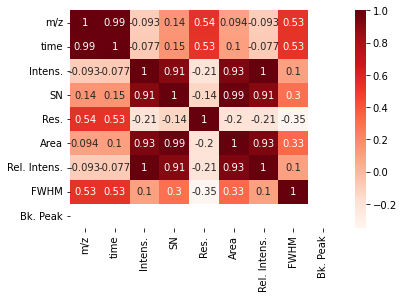

In [425]:
cor = example.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [426]:
## select uncorrelated features
FEATURES = ['m/z', 'Rel. Intens.', 'Res.', 'FWHM']

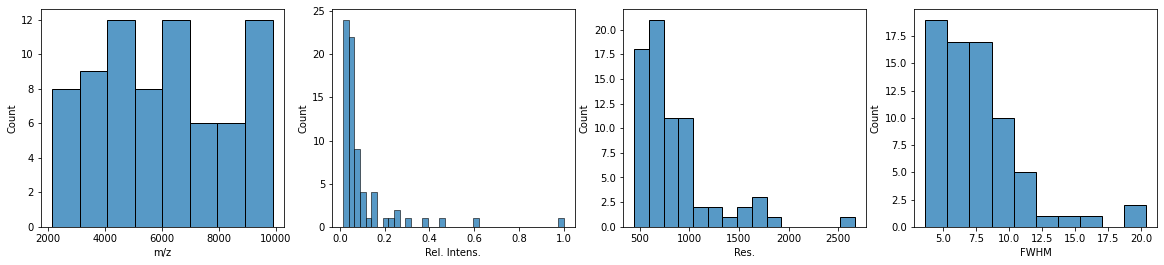

In [427]:
fig, axs = plt.subplots(1,4, figsize=(20, 4))
for features in FEATURES:
    sns.histplot(example[features], ax = axs[FEATURES.index(features)])

Посмотрим на масс-спектры для нескольих примеров

In [428]:
def colors_from_values(values, palette_name):
    values = np.array(values)
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

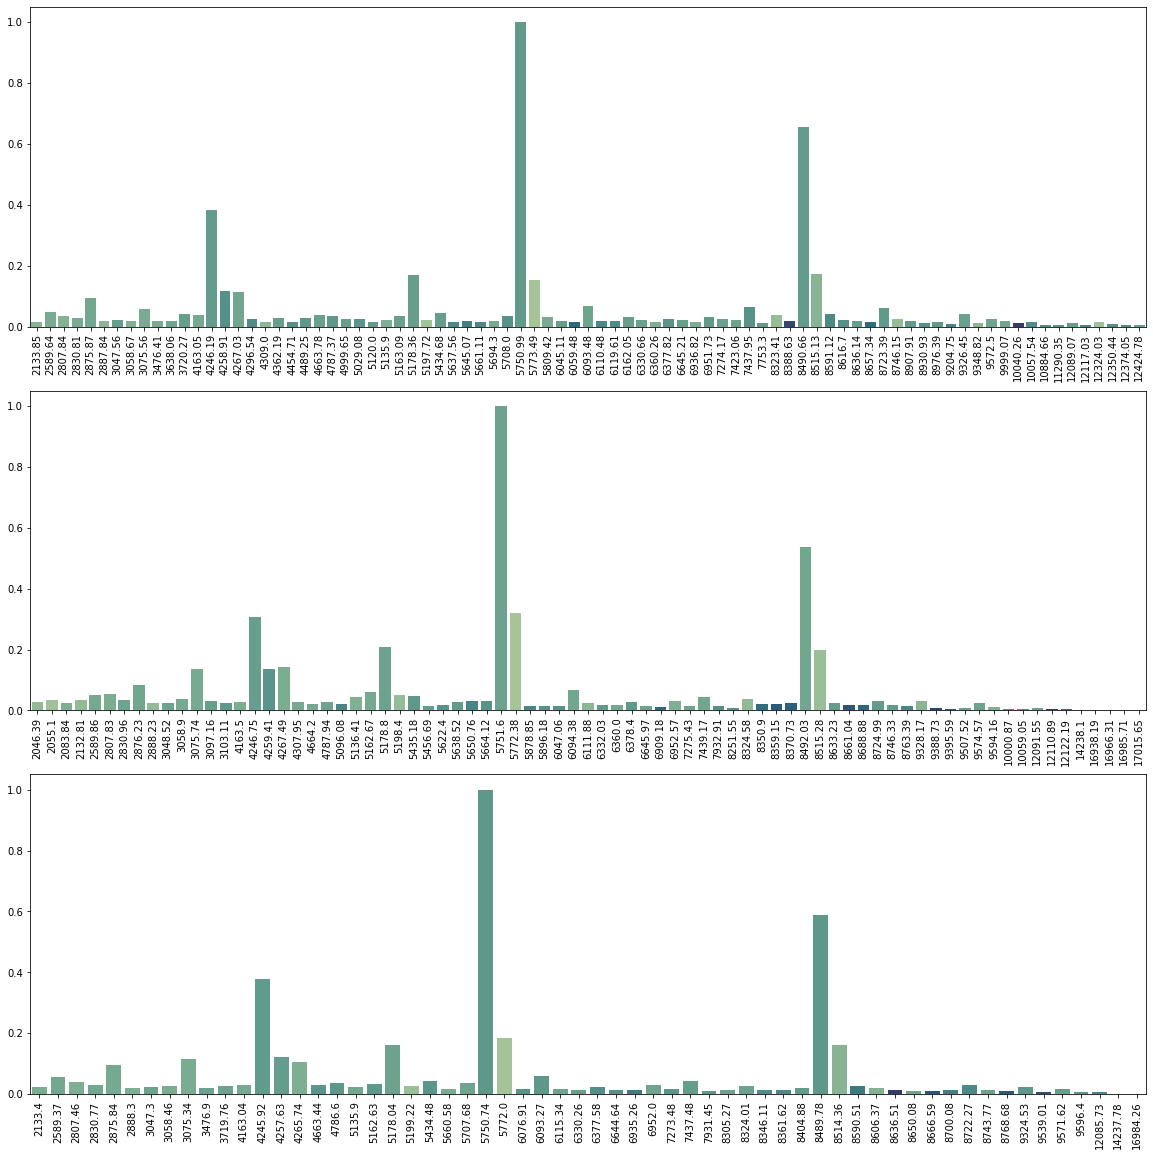

In [429]:
fig, axs = plt.subplots(3,1, figsize=(20,20))
strain = "Acinetobacter baumani_64"
i = 0
for ids in [2,6,8]:
    tmp = train_df.loc[(train_df.strain == strain)].iloc[ids]
    mz = [np.round(x, 2) for x in tmp['m/z']]
    ax =  axs[i]
    sns.barplot(data = tmp, x=mz, y = 'Rel. Intens.', 
                palette=colors_from_values(tmp['Res.'], 'crest'),
                ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    i=i+1

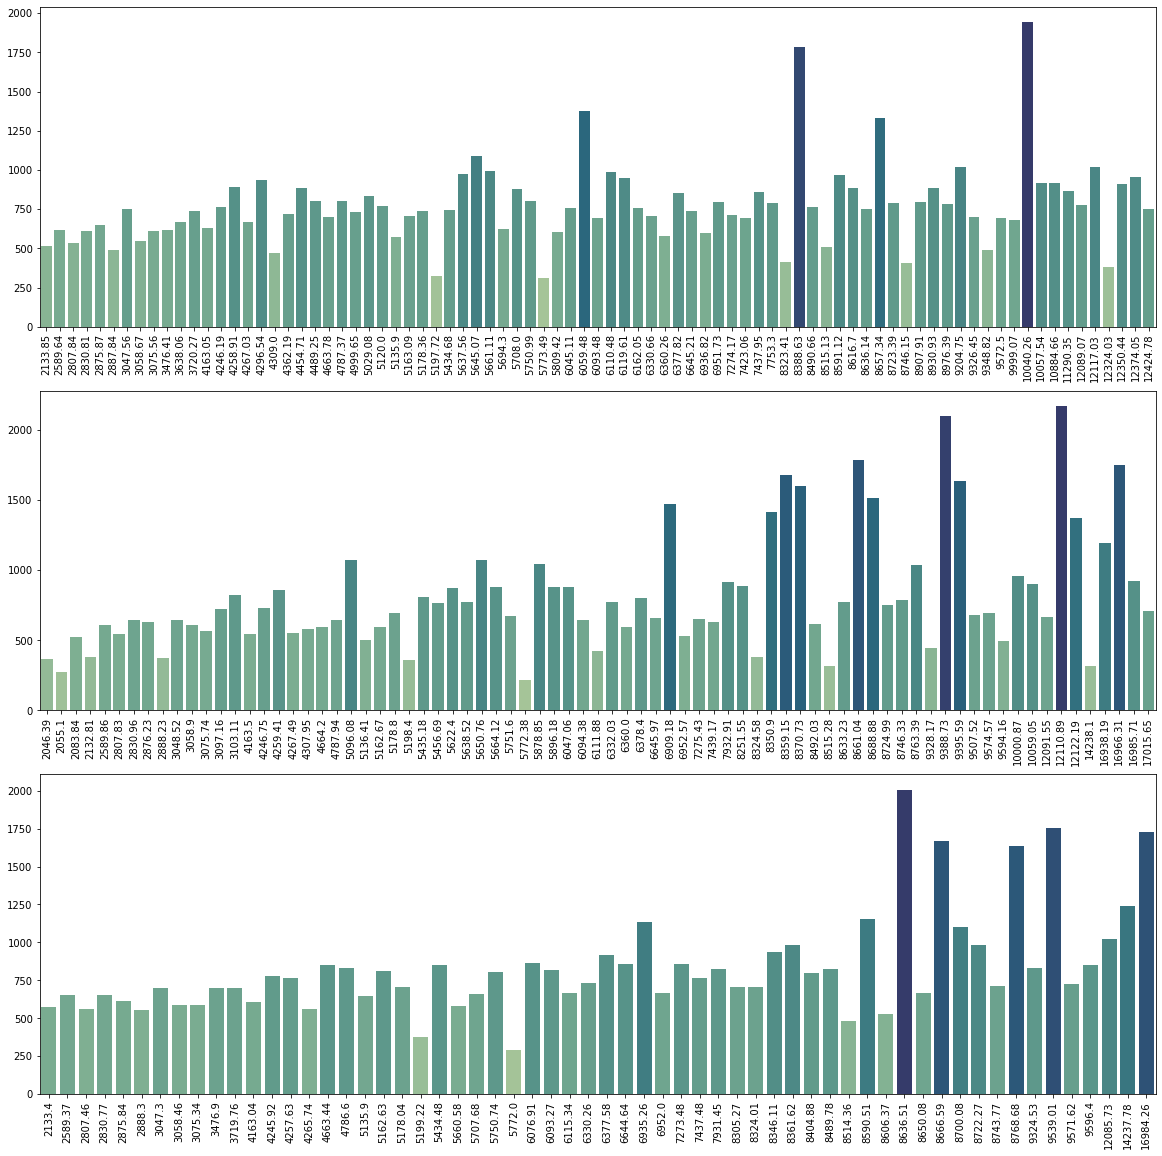

In [430]:
fig, axs = plt.subplots(3,1, figsize=(20,20))
strain = "Acinetobacter baumani_64"
i = 0
for ids in [2,6,8]:
    tmp = train_df.loc[(train_df.strain == strain)].iloc[ids]
    mz = [np.round(x, 2) for x in tmp['m/z']]
    ax =  axs[i]
    sns.barplot(data = tmp, x=mz, y = 'Res.', 
                palette=colors_from_values(tmp['Res.'], 'crest'),
                ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    i=i+1

Создаим спектры, которые удобно сравнитвать между собой в виде векторов в фиксированом диапазоне, и уберем необходимость использовать переменную "m/z".

In [431]:
# орпеделим диапазон парамтеров
min(train_df['m/z'].apply(min)), max(train_df['m/z'].apply(max))

(2040.804289776974, 17241.93492389016)

In [432]:
def create_speactr(mz, intens):
    spec = []
    for i in range(200, 1750):
        if i in mz:
            spec.append(intens[mz.index(i)])
        else:
            spec.append(0)
    return spec

In [433]:
def prepocess_data(data):
    data['mz'] = data['m/z'].apply(lambda x: [int(x_i // 10) for x_i in x])
    data['intens'] = data.apply(lambda d: create_speactr(d['mz'], d['Rel. Intens.']),
                           axis = 1)
    data['res'] = data.apply(lambda d: create_speactr(d['mz'], d['Res.']),
                           axis = 1)
    data['fwhm'] = data.apply(lambda d: create_speactr(d['mz'], d['FWHM']),
                           axis = 1)
    return data

In [434]:
train_df = prepocess_data(train_df)

Перемешаем данные, чтобы классы не шли по порядку

In [435]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

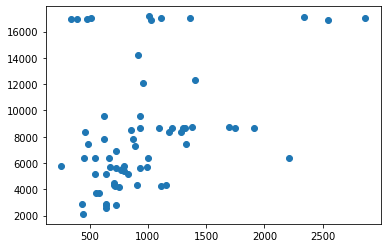

In [436]:
sample = train_df.iloc[0]
x = sample['Res.']
y = sample['m/z']
plt.scatter(x, y)
plt.show()

In [437]:
train_df = train_df.drop(['time', 'Intens.', 'SN', 'Area', 'Bk. Peak', 'm/z'], axis = 1)
#FEATURES = ['m/z', 'Rel. Intens.', 'Res.', 'FWHM']

In [438]:
train_df.head(2)

,strain,Res.,Rel. Intens.,FWHM,n_peak,mz,intens,res,fwhm
0,Acinetobacter baumani_74,"[441.2736138914918, 639.5660463797733, 642.902...","[0.01991703520105712, 0.02577962270799574, 0.0...","[4.831851697459115, 4.048543893202805, 4.36623...",66,"[213, 258, 280, 283, 287, 288, 374, 416, 374, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 441.27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.8318..."
1,Staphilococcus aureus_16,"[492.5176486867362, 460.9403747144156, 466.431...","[0.05513128473376375, 0.08155730291103787, 0.2...","[4.20461798056931, 4.577402556961715, 4.592603...",89,"[207, 210, 214, 215, 216, 218, 221, 221, 224, ...","[0, 0, 0, 0, 0, 0, 0, 0.05513128473376375, 0, ...","[0, 0, 0, 0, 0, 0, 0, 492.5176486867362, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 4.20461798056931, 0, 0, ..."


In [439]:
train_df.loc[:,'FWHM_mean'] = train_df['FWHM'].agg(lambda a : np.mean(a))
train_df.loc[ : , 'mz_mean'] = train_df['mz'].agg(lambda a : np.mean(a))

In [440]:
train_df.head(2)

,strain,Res.,Rel. Intens.,FWHM,n_peak,mz,intens,res,fwhm,FWHM_mean,mz_mean
0,Acinetobacter baumani_74,"[441.2736138914918, 639.5660463797733, 642.902...","[0.01991703520105712, 0.02577962270799574, 0.0...","[4.831851697459115, 4.048543893202805, 4.36623...",66,"[213, 258, 280, 283, 287, 288, 374, 416, 374, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 441.27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.8318...",10.322872,825.253731
1,Staphilococcus aureus_16,"[492.5176486867362, 460.9403747144156, 466.431...","[0.05513128473376375, 0.08155730291103787, 0.2...","[4.20461798056931, 4.577402556961715, 4.592603...",89,"[207, 210, 214, 215, 216, 218, 221, 221, 224, ...","[0, 0, 0, 0, 0, 0, 0, 0.05513128473376375, 0, ...","[0, 0, 0, 0, 0, 0, 0, 492.5176486867362, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 4.20461798056931, 0, 0, ...",6.876620,525.722222


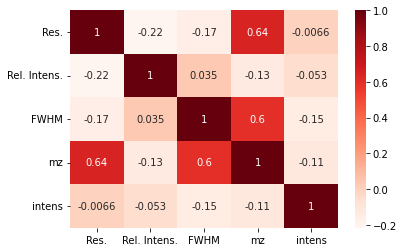

In [441]:
#train_df.groupby('strain').agg({'mz_mean' : lambda a : np.mean(a)})
FEATURES_list = ['Res.', 'Rel. Intens.', 'FWHM', 'mz', 'intens']

example = train_df[FEATURES_list]\
         .loc[(train_df.strain == 'Staphilococcus aureus_6 1006')].iloc[0]
example = pd.DataFrame(list(example)).T
example.columns = FEATURES_list

cor = example.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

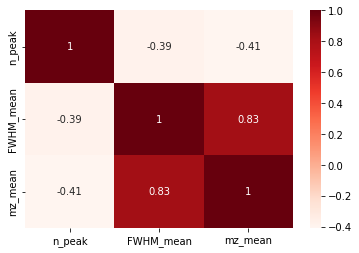

In [442]:
cor = train_df[['n_peak', 'FWHM_mean', 'mz_mean']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# <center> Обучение моделей <center>

Разобьем выборку на валидационную и тренировочную так, чтобы хотя бы один пример из каждого класса присутствавал
в валидаицонной выборке. После разбиения уберем два класса из тренировочный выборки, чтобы можно было определить их 
как 'new'.

_Note_:  рекомендуем рассмотреть разные вариатны разбиения на тренировочную и валидационную выборку для определения оптиматльных парпамтеров. 

In [443]:
np.random.seed(142)
val_ds = pd.DataFrame()
train_ds = pd.DataFrame()
for strain in train_df.strain.unique():
    n = np.random.randint(1,4)
    ids = random.sample(list(train_df.loc[train_df.strain == strain].index), n)
    val_ds = pd.concat([val_ds, train_df.loc[ids]])
    train_ids = list(set(train_df.loc[train_df.strain == strain].index) - set(ids))
    train_ds = pd.concat([train_ds, train_df.loc[train_ids]])
    

In [444]:
val_ds.shape, train_ds.shape

((54, 11), (1138, 11))

In [445]:
random.seed(111)
val_strain = random.sample(sorted(list(val_ds.strain.unique())), 2)
val_strain

['Acinetobacter baumani_64', 'Pseudomonas fluorescence_965']

In [446]:
train_ds = train_ds[~train_ds.strain.isin(val_strain)]

In [447]:
val_ds.loc[:,'target'] = val_ds.strain
val_ds.loc[val_ds.strain.isin(val_strain),'target'] = 'new'

In [448]:
val_ds = val_ds.sample(frac=1)
train_ds = train_ds.sample(frac=1)

In [449]:
def make_x(df, col):
    X = []
    for i in df.index:
        row = df.loc[i,col]
        #print(row)
        X.append(np.array(row))
    return np.array(X)

## Многоклассовый классификатор

In [450]:
train_ds.head(2)

,strain,Res.,Rel. Intens.,FWHM,n_peak,mz,intens,res,fwhm,FWHM_mean,mz_mean
632,Staphilococcus aureus_19 MRSA,"[580.7225608719237, 445.3126677261632, 554.348...","[0.0889914644187017, 0.1175756384825702, 0.056...","[3.690517090488356, 4.839323964513824, 3.90595...",81,"[214, 215, 216, 218, 224, 224, 282, 234, 233, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 580...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.6...",8.112104,580.804878
345,Staphilococcus aureus_11 K817,"[658.6625613925063, 492.4047700025939, 570.440...","[0.05292183011910705, 0.2054538143062064, 0.08...","[3.144420382225234, 4.349986575908588, 3.77596...",78,"[207, 214, 215, 216, 218, 218, 229, 251, 275, ...","[0, 0, 0, 0, 0, 0, 0, 0.05292183011910705, 0, ...","[0, 0, 0, 0, 0, 0, 0, 658.6625613925063, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 3.144420382225234, 0, 0,...",7.163089,532.051282


In [451]:
X = make_x(train_ds, col='intens')
X = np.hstack((X, make_x(train_ds, col='res')))
X = np.hstack((X, make_x(train_ds, col='fwhm')))
y = np.array(train_ds['strain'])

**Проверим градиентный бустинг**

In [452]:
params = {
    'loss' : ['log_loss', 'deviance', 'exponential'],
    'learning_rate' : [0.01, 0.1],
    'criterion' : ['friedman_mse', 'squared_error', 'mse'],
    'max_depth' : [4]
}

In [453]:
from sklearn.ensemble import GradientBoostingClassifier

In [454]:
#from sklearn.ensemble import GradientBoostingClassifier
#mod = GradientBoostingClassifier()
#model = GridSearchCV(mod, params)
model = GradientBoostingClassifier(learning_rate=0.1, loss = 'log_loss', criterion = 'squared_error', max_depth=3)
model.fit(X, y)

GradientBoostingClassifier(criterion='squared_error')

In [455]:
#model.best_params_
'''
{'criterion': 'squared_error',
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 4}
'''

"\n{'criterion': 'squared_error',\n 'learning_rate': 0.1,\n 'loss': 'log_loss',\n 'max_depth': 4}\n"

In [456]:
X_pred = make_x(val_ds, col='intens')
X_pred = np.hstack((X_pred, make_x(val_ds, col='res')))
X_pred = np.hstack((X_pred, make_x(val_ds, col='fwhm')))
val_ds.loc[:,'class_name'] = model.predict(X_pred)
val_ds.loc[:,'class_name_proba'] =  np.max(model.predict_proba(np.array(X_pred)), axis = 1)
# посмотрим на качестов модели, то выделения новых классов
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.9295238095238096

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.75229566, 0.77044777, 0.78859987, 0.80675198, 0.82490409,
        0.84305619, 0.8612083 , 0.8793604 , 0.89751251, 0.91566462,
        0.93381672]),
 <BarContainer object of 10 artists>)

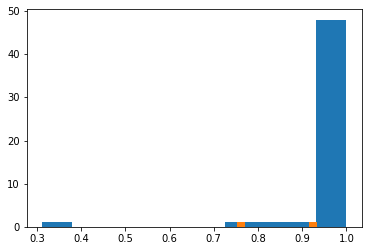

In [457]:
plt.hist(val_ds.loc[val_ds.target != 'new'].class_name_proba)
plt.hist(val_ds.loc[val_ds.target == 'new'].class_name_proba)

In [458]:
val_ds.loc[val_ds.class_name_proba < 0.2,'class_name'] = 'new'
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.9295238095238096

In [459]:
#model = SVC(gamma='auto', kernel='sigmoid', probability=True)
#clf = make_pipeline(StandardScaler(), model)
#clf.fit(X, y)

**Проверим случайный лес**

In [460]:
from sklearn.ensemble import RandomForestClassifier

In [461]:
params = {
    'criterion' : ['gini', 'entropy', 'log_loss']
}
{'criterion': 'gini'}

{'criterion': 'gini'}

In [462]:
mod = RandomForestClassifier()
model = GridSearchCV(mod, params)
#model = GradientBoostingClassifier(learning_rate=0.1, loss = 'log_loss', criterion = 'squared_error', max_depth=4)
model.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss']})

In [463]:
model.best_params_

{'criterion': 'gini'}

In [464]:
model = RandomForestClassifier(criterion='gini')
model.fit(X,y)

RandomForestClassifier()

In [465]:
X_pred = make_x(val_ds, col='intens')
X_pred = np.hstack((X_pred, make_x(val_ds, col='res')))
X_pred = np.hstack((X_pred, make_x(val_ds, col='fwhm')))

val_ds.loc[:,'class_name'] = model.predict(X_pred)
val_ds.loc[:,'class_name_proba'] =  np.max(model.predict_proba(np.array(X_pred)), axis = 1)
# посмотрим на качестов модели, то выделения новых классов
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.9485714285714286

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.28 , 0.292, 0.304, 0.316, 0.328, 0.34 , 0.352, 0.364, 0.376,
        0.388, 0.4  ]),
 <BarContainer object of 10 artists>)

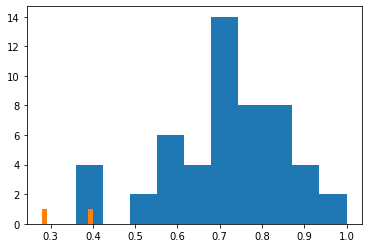

In [466]:
plt.hist(val_ds.loc[val_ds.target != 'new'].class_name_proba)
plt.hist(val_ds.loc[val_ds.target == 'new'].class_name_proba)

In [467]:
val_ds.loc[val_ds.class_name_proba < 0.2,'class_name'] = 'new'
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.9485714285714286

### проверяем качество модели на валидационной выборке

In [468]:
X = make_x(train_ds, col='intens')
X = np.hstack((X, make_x(train_ds, col='res')))
X = np.hstack((X, make_x(train_ds, col='fwhm')))

X_pred = make_x(val_ds, col='intens')
X_pred = np.hstack((X_pred, make_x(val_ds, col='res')))
X_pred = np.hstack((X_pred, make_x(val_ds, col='fwhm')))

In [469]:
val_ds.loc[:,'class_name'] = model.predict(X_pred)
val_ds.loc[:,'class_name_proba'] =  np.max(model.predict_proba(np.array(X_pred)), axis = 1)

In [470]:
# посмотрим на качестов модели, то выделения новых классов
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.9485714285714286

Новые классы будем орпеделять по вероятности определения класса

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.28 , 0.292, 0.304, 0.316, 0.328, 0.34 , 0.352, 0.364, 0.376,
        0.388, 0.4  ]),
 <BarContainer object of 10 artists>)

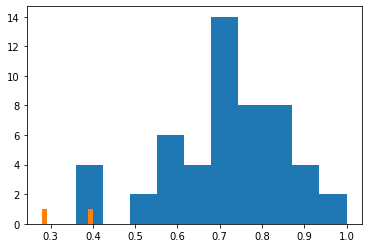

In [471]:
plt.hist(val_ds.loc[val_ds.target != 'new'].class_name_proba)
plt.hist(val_ds.loc[val_ds.target == 'new'].class_name_proba)

In [472]:
val_ds.loc[val_ds.class_name_proba < 0.2,'class_name'] = 'new'

In [473]:
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.9485714285714286

Как мы видим, после добавления метки 'new' значение метрики возрасло

### сохранение модели

переобучим модель на всей тренировочной выборке, так как мы исключали классы для валидации

In [43]:
X = make_x(train_df, col='intens')
y = np.array(train_df['strain'])
model = SVC(gamma='auto', kernel='sigmoid', probability=True)
clf = make_pipeline(StandardScaler(), model)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', kernel='sigmoid', probability=True))])

In [44]:
swmPickle = open('models/baseline_clf.pkl', 'wb') 
pickle.dump(clf, swmPickle)   

## Набор бинарных классификатров для каждого тарегта

In [474]:
X = make_x(train_ds, col='intens')
X = np.hstack((X, make_x(train_ds, col='res')))
X = np.hstack((X, make_x(train_ds, col='fwhm')))

X_pred = make_x(val_ds, col='intens')
X_pred = np.hstack((X_pred, make_x(val_ds, col='res')))
X_pred = np.hstack((X_pred, make_x(val_ds, col='fwhm')))

In [475]:
# делаем бинарных тарегет для каждого класса
Y = []
for strain in train_ds.strain.unique():
    Y.append(np.array(train_ds.strain == strain))

In [476]:
# сохраняем порядок классов
class_order = train_ds.strain.unique()

так как негативных примеров для каждого таргета в разы больше положительных, оставим в выборке только примеры в соотношении 3:1 (негативные:положительные)

In [477]:
res = []
for i,y in enumerate(Y):
    idx_pos = np.where(y ==True)[0]
    idx_neg = np.where(y == False)[0]
    random.shuffle(idx_neg)
    idx = sorted(np.concatenate((idx_pos,idx_neg[:3*len(idx_pos)])))
    
    model = RandomForestClassifier()
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X[idx,:], y[idx])
    res.append(clf.predict_proba(X_pred)[:,1])

### проверяем качество модели на валидационной выборке

In [478]:
res = np.array(res).T

In [479]:
# выбираем класс с наибльшей вероятностью или ставим 0, если веротяность меньше 0.5
class_name = []
for res_i in res:
    if max(res_i) > 0.5:
        class_name.append(class_order[np.where(res_i == max(res_i))[0]].item())
    else:
        class_name.append('new')

In [480]:
val_ds.loc[:,'class_name'] = class_name

In [481]:
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.980952380952381

Данная модель показала самое высокое значение метрики, поэтому берем ее как бейзлайн для данной задачи.

### сохраняем модели

In [482]:
# переобучаем на полной выборке
res = []
for i,y in enumerate(Y):
    idx_pos = np.where(y ==True)[0]
    idx_neg = np.where(y == False)[0]
    random.shuffle(idx_neg)
    idx = sorted(np.concatenate((idx_pos,idx_neg[:3*len(idx_pos)])))
    
    model = RandomForestClassifier()
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X[idx,:], y[idx])
    # save model
    strain = class_order[i]
    pickle.dump(clf, open(f'sample_solution/models/baseline_clf_{strain}.pkl', 'wb'))

# <center> Формат решения <center>

В проверяющую систему необходимо отправить код алгоритма, запакованный в ZIP-архив. Архив должен содержать следующие файлы: 
 * solution.py -- файл с кодом запуска решения
 * models/ -- директория, где хранятся обученные модели
 * requiremnts.txt -- необходимые библиотеки для запуска решения
 * \*.py -- вспомогательные модули
 * metadata.json  -- обязательный файл для запуска докера, который содержит название docker image и команду для расчета предсказаний (см. описание задачи)
 
Решение должно быть реализовано в виде программы, которая на вход принимает файл `test.xlsx` и на выходе выдает CSV таблицу (`results.csv`). Файл `results.csv` должен в обязательном порядке содержать поле `class_name`  -- предсказанный класс (название штамма бактерии или метка 'new')